# **Auxilliary**

In [1]:
# Import libraries
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Import custom modules
from dataset import dataset_generator
from bot.bot import Bot
from modelling import data_preparation as dp
from modelling import model_trainer as mt

# Redirect standard output to stdout file
path = "binary-options-research/"
if path not in sys.path:
    sys.path.append(path)
sys.stdout = open("stdout", 'w')

# Set random seed for reproducibility
np.random.seed(42)

# Automatically reload modules before executing
%load_ext autoreload
%autoreload 2

# **Data Generation**

In [2]:
# Generate dataset by specifying the asset and time frame
dataset_generator.make(["BTCUSDT"], "1h")

# **Data Analysis**

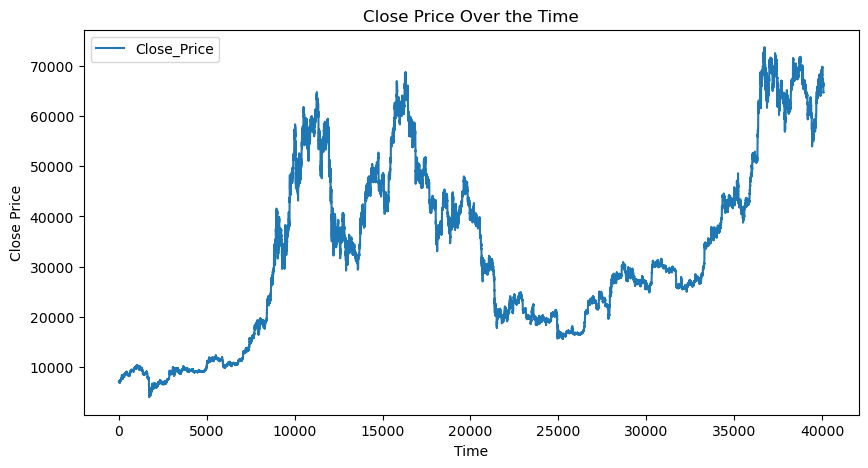

In [3]:
# Define the path to the CSV file containing BTCUSDT data and load it into a pandas DataFrame
path_of_file = 'dataset/BTCUSDT-1h-2020_2024.csv'
df_df = pd.read_csv(path_of_file)

# Drop any rows with missing values and extract close prices for plotting
df_df = df_df.dropna(subset=['close'])
df_df['close']

# Create a figure and plot the closing prices
plt.figure(figsize=(10, 5))
plt.plot(df_df['close'], label='Close_Price')
plt.title('Close Price Over the Time')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Perform the Augmented Dickey-Fuller test and display the results
result_adf = adfuller(df_df['close'])
print('\nAugmented Dickey-Fuller Test on "close" column:')
print(f'ADF Statistic: {result_adf[0]}')
print(f'p-value: {result_adf[1]}')
print('Critical Values:')
for key, value in result_adf[4].items():
    print(f'   {key}: {value}')

<Figure size 1200x600 with 0 Axes>

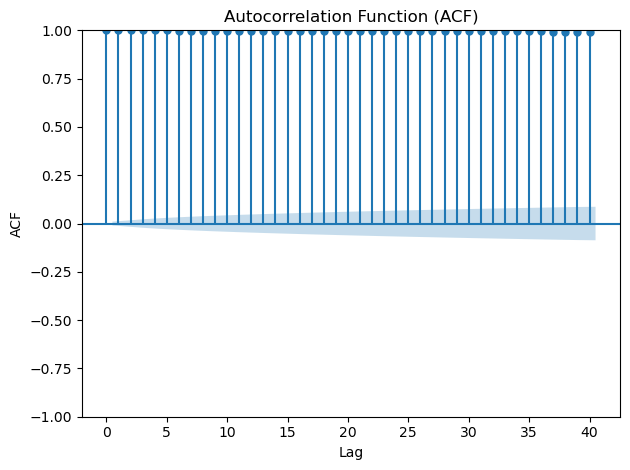

In [4]:
# Create a figure and plot the Autocorrelation Function of closing prices
plt.figure(figsize=(12, 6))
plot_acf(df_df['close'], lags=40, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

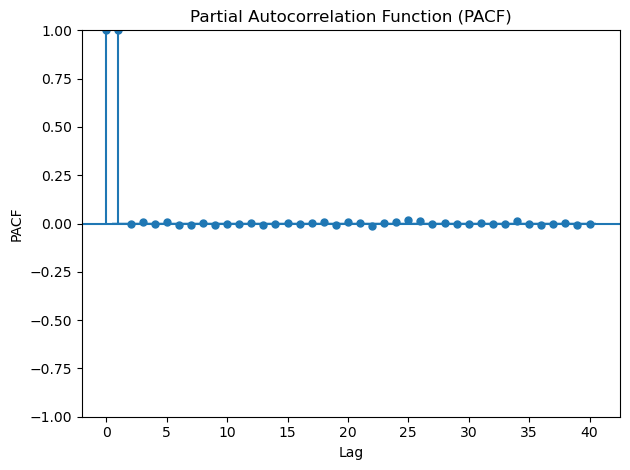

In [5]:
# Create a figure and plot the Partial Autocorrelation Function of closing prices
plt.figure(figsize=(12, 6))
plot_pacf(df_df['close'], lags=40, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.tight_layout()
plt.show()

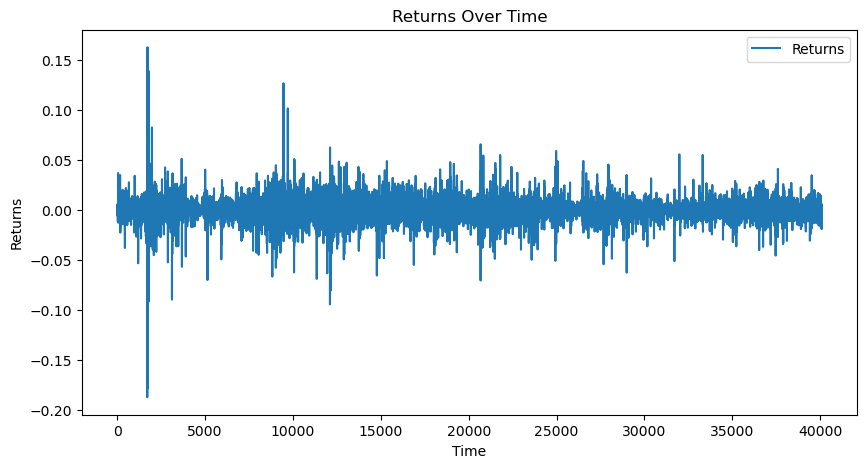

In [6]:
# Calculate the percentage change in closing prices to compute returns and replace NaNs with 0
df_df['returns'] = df_df['close'].pct_change()
df_df['returns'] = df_df['returns'].fillna(0)

# Create a figure and plot the returns over time
plt.figure(figsize=(10, 5))
plt.plot(df_df['returns'], label='Returns')
plt.title('Returns Over Time')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

# Perform the Augmented Dickey-Fuller test and display the results
result1 = adfuller(df_df['returns'])
print('\nAugmented Dickey-Fuller Test on "returns" column:')
print(f'ADF Statistic: {result1[0]}')
print(f'p-value: {result1[1]}')
print('Critical Values:')
for key, value in result1[4].items():
    print(f'   {key}: {value}')

<Figure size 1200x600 with 0 Axes>

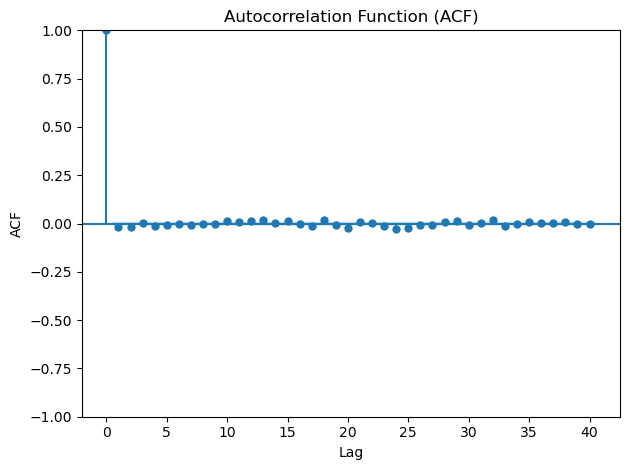

In [7]:
# Create a figure and plot the Autocorrelation Function of closing prices
plt.figure(figsize=(12, 6))
plot_acf(df_df['returns'], lags=40, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

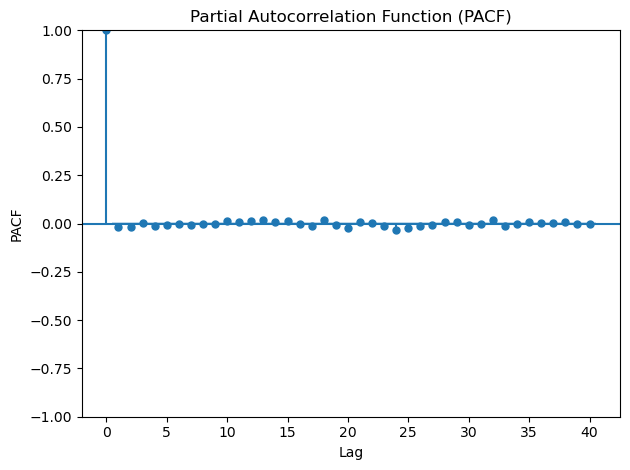

In [8]:
# Create a figure and plot the Partial Autocorrelation Function of closing prices
plt.figure(figsize=(12, 6))
plot_pacf(df_df['returns'], lags=40, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.tight_layout()
plt.show()

# **Feature Extraction**

In [9]:
# Load the dataset containing BTCUSDT data into a pandas DataFrame
candles = pd.read_csv(f"dataset/BTCUSDT-1h-2020_2024.csv", index_col=0)

# Filter the data to include only the training period from 2020-01-01 to 2023-01-01
candles_training = candles[(candles['open_time'] >= '2020-01-01') & (candles['open_time'] < '2023-01-01')].reset_index(drop=True)

# Initialize a Bot object with the training data and start the pattern feature exctraction process (logging = 0)
bot = Bot(candles_training, 0, None, None)
bot._pattern_features_service(30)

# **Model Training**

In [10]:
# Load the feature data into a pandas DataFrame and filter rows containing the Double Bottom pattern
features = pd.read_csv("features/features_1h_30.csv")
features = features[features['pattern'] == "Double Bottom"].reset_index(drop=True)

# Split the data into training, validation, and test sets
X_train, y_train, X_valid, y_valid, X_test, y_test = dp.split_data(features)
print("Writing data")

# Save the split datasets
dp.save_data(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [11]:
# Load the previously saved training, validation, and test datasets
X_train, y_train, X_valid, y_valid, X_test, y_test = dp.load_data()

# Perform hyperparameter tuning using the training and validation datasets
mt.find_hyper_params(X_train, y_train, X_valid, y_valid)

In [12]:
# Define the hyperparameters for the model as a dictionary
hyper = {'base_score': 2, 'colsample_bylevel': 10, 'colsample_bynode': 0, 'colsample_bytree': 3, 'gamma': 3, 'learning_rate': 9, 'max_depth': 14, 'min_child_weight': 2, 'n_estimators': 2, 'reg_alpha': 3, 'reg_lambda': 2, 'scale_pos_weight': 10, 'subsample': 3}

# Load the training, validation, and test datasets
X_train, y_train, X_valid, y_valid, X_test, y_test  = dp.load_data()

# Train the model using the specified hyperparameters and datasets
mt.fit_model(X_train, y_train, X_valid, y_valid, X_test, y_test, hyper, "DBmodel_1h_30") 

In [13]:
# Load the feature data into a pandas DataFrame and filter rows containing the Double Top pattern
features = pd.read_csv("features/features_1h_30.csv")
features = features[features['pattern'] == "Double Top"].reset_index(drop=True)

# Split the data into training, validation, and test sets
X_train, y_train, X_valid, y_valid, X_test, y_test = dp.split_data(features)
print("Writing data")

# Save the split datasets
dp.save_data(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [14]:
# Load the previously saved training, validation, and test datasets
X_train, y_train, X_valid, y_valid, X_test, y_test = dp.load_data()

# Perform hyperparameter tuning using the training and validation datasets
mt.find_hyper_params(X_train, y_train, X_valid, y_valid)

In [15]:
# Define the hyperparameters for the model as a dictionary
hyper = {'base_score': 0, 'colsample_bylevel': 10, 'colsample_bynode': 8, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 7, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 5, 'reg_alpha': 3, 'reg_lambda': 3, 'scale_pos_weight': 10, 'subsample': 7}

# Load the training, validation, and test datasets
X_train, y_train, X_valid, y_valid, X_test, y_test  = dp.load_data()

# Train the model using the specified hyperparameters and datasets
mt.fit_model(X_train, y_train, X_valid, y_valid, X_test, y_test, hyper, "DTmodel_1h_30") 

# **Forward Testing**

In [16]:
# Load the dataset containing BTCUSDT data into a pandas DataFrame
candles = pd.read_csv(f"dataset/BTCUSDT-1h-2020_2024.csv", index_col=0)

# Filter the data to include only the testing period from 2023-01-01
candles_testing = candles[(candles['open_time'] >= '2023-01-01')].reset_index(drop=True)

# Initialize a Bot object with the testing data and start the forward testing process (logging = 1)
bot = Bot(candles_testing, 1, "DBmodel_1h_30", "DTmodel_1h_30")
bot._pattern_features_service(30)